In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import time
from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.utils import plot_model

Segmentation Models: using `keras` framework.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.13.1
2.14.0


In [3]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=5 #Number of classes for segmentation

In [4]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("data/data_batches/batch_1/patch_img/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(img_path)
        img = cv2.imread(img_path, 1)       
        # img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

(4667, 256, 256, 3)


In [5]:
#Capture mask/label info as a list
train_masks = [] 

for directory_path in glob.glob("data/data_batches/batch_1/patch_mask/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(mask_path)
        mask = cv2.imread(mask_path, 0)       
        # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

(4667, 256, 256)


In [6]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\sagni\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4], dtype=int64)

In [7]:
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
# X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
# # #Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.3, random_state = 0)


#Full Data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4]


In [8]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [9]:
# Assuming you have one-hot encoded masks
# train_masks_cat and test_masks_cat are your one-hot encoded masks

num_classes = n_classes  # Set the number of classes to 5

# For training data
class_pixel_counts_train = np.sum(train_masks_cat, axis=(0, 1, 2))
print("Class-wise pixel counts for training data:")
for class_index in range(num_classes):
    pixel_count = class_pixel_counts_train[class_index]
    print(f"Class {class_index}: {pixel_count} pixels")

# For testing data
class_pixel_counts_test = np.sum(test_masks_cat, axis=(0, 1, 2))
print("Class-wise pixel counts for testing data:")
for class_index in range(num_classes):
    pixel_count = class_pixel_counts_test[class_index]
    print(f"Class {class_index}: {pixel_count} pixels")


Class-wise pixel counts for training data:
Class 0: 16777216.0 pixels
Class 1: 4294513.0 pixels
Class 2: 16777216.0 pixels
Class 3: 16777216.0 pixels
Class 4: 7683051.0 pixels
Class-wise pixel counts for testing data:
Class 0: 16777216.0 pixels
Class 1: 956140.0 pixels
Class 2: 16777216.0 pixels
Class 3: 3962936.0 pixels
Class 4: 1740489.0 pixels


In [10]:
#Reused parameters in all models

n_classes=5
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

from tensorflow.keras.optimizers.legacy import Adam
optimizer = Adam(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.20, 0.20, 0.20, 0.20, 0.20])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (2 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [11]:
# Add print statements to check tensor shapes
print("Input shapes:")
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

Input shapes:
X_train shape: (3733, 256, 256, 3)
y_train_cat shape: (3733, 256, 256, 5)
X_test shape: (934, 256, 256, 3)
y_test_cat shape: (934, 256, 256, 5)


In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

BACKBONE = 'resnet34'
#ModelCheckpoint callback saves a model at some interval. 
filepath=f'Segmentation_Models/{BACKBONE}/CheckPoints/weights-improvement_{BACKBONE}.hdf5' #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor= 'val_iou_score', verbose= 1, save_best_only= True, mode= 'max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor="val_iou_score", min_delta=0, patience= 20, verbose= 1, mode= "max", baseline= None, restore_best_weights= False, start_from_epoch= 20)
#This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(f'Segmentation_Models/{BACKBONE}/training-history-{BACKBONE}.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [6]:
###Model 1

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optimizer, total_loss, metrics=metrics)

print(model1.summary())
file = f'Segmentation_Models/{BACKBONE}'
os.makedirs(file, exist_ok=True)
# Plot the model architecture
plot_model(model1, show_shapes=True, show_layer_names=True, to_file=f'{file}/unet_model_{BACKBONE1}.png')

history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=2, 
          epochs=200,
          verbose=1,
          validation_data=(X_test1, y_test_cat),
          callbacks = callbacks_list)


model1.save('SavedModels/res34_backbone_200epochs.hdf5')

NameError: name 'sm' is not defined

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
BACKBONE = 'inceptionv3'
#ModelCheckpoint callback saves a model at some interval. 
filepath=f'Segmentation_Models/{BACKBONE}/CheckPoints/weights-improvement_{BACKBONE}.hdf5' #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor="val_iou_score", min_delta=0, patience= 20, verbose= 1, mode="max", baseline= None, restore_best_weights= False, start_from_epoch= 20)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(f'Segmentation_Models/{BACKBONE}/training-history-{BACKBONE}.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optimizer, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=2, 
          epochs=200,
          verbose=1,
          validation_data=(X_test2, y_test_cat),
          callbacks = callbacks_list)


model2.save('SavedModels/inceptionv3_backbone_200epochs.hdf5')


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
BACKBONE = 'vgg16'
#ModelCheckpoint callback saves a model at some interval. 
filepath=f'Segmentation_Models/{BACKBONE}/CheckPoints/weights-improvement_{BACKBONE}.hdf5' #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor="val_iou_score", min_delta=0, patience= 20, verbose= 1, mode="max", baseline= None, restore_best_weights= False, start_from_epoch= 20)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(f'Segmentation_Models/{BACKBONE}/training-history-{BACKBONE}.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
###Model 3

BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)
# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optimizer, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())

history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=2, 
          epochs=200,
          verbose=1,
          validation_data=(X_test3, y_test_cat),
          callbacks = callbacks_list)


model3.save('SavedModels/vgg16_backbone_200epochs.hdf5')

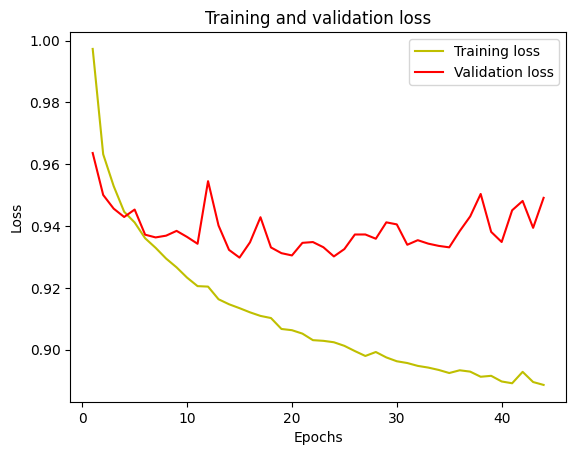

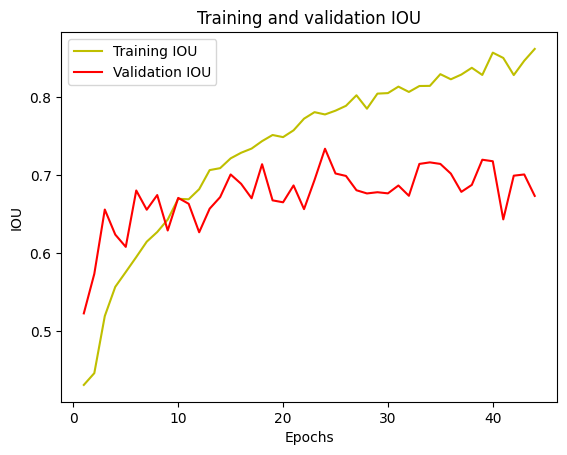

In [15]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [7]:
from keras.models import load_model
### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('Segmentation_Models/resnet34/CheckPoints/weights-improvement_resnet34.hdf5', compile=False)
# model2 = load_model('saved_models/inceptionv3_backbone_200epochs.hdf5', compile=False)
# model1 = load_model('SavedModels/vgg19_backbone_200epochs.hdf5', compile=False)
#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

NameError: name 'X_test1' is not defined

In [1]:
# Assuming n_classes = 5
n_classes = 5

# Calculate IoU for each class
class_IoU = []
for i in range(n_classes):
    numerator = values[i, i]
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i]
    class_IoU.append(numerator / denominator)

# Print IoU for each class
for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_IoU[i]}")


IoU for class 1 is: 0.9999999999
IoU for class 2 is: 0.4999999999875
IoU for class 3 is: 0.9999999999666667
IoU for class 4 is: 0.6666666666555555
IoU for class 5 is: 0.99999999998


In [4]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

#Verify the prediction on first image

NameError: name 'IOU_keras' is not defined

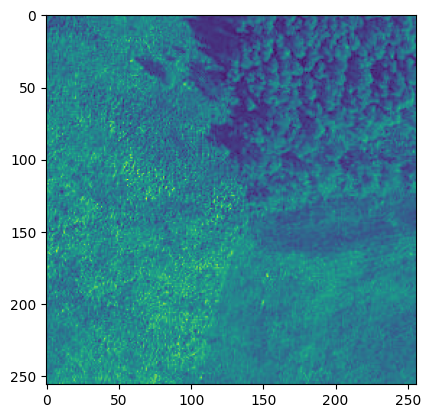

In [18]:
plt.imshow(train_images[0, :,:,0])

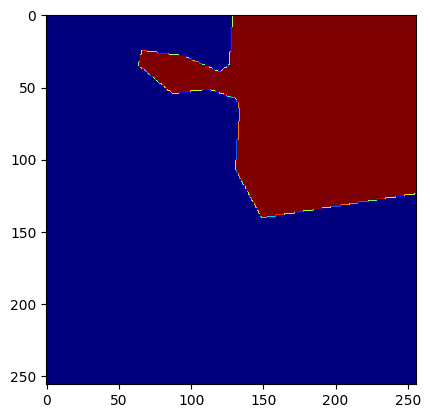

In [19]:
plt.imshow(train_masks[0], cmap='jet')

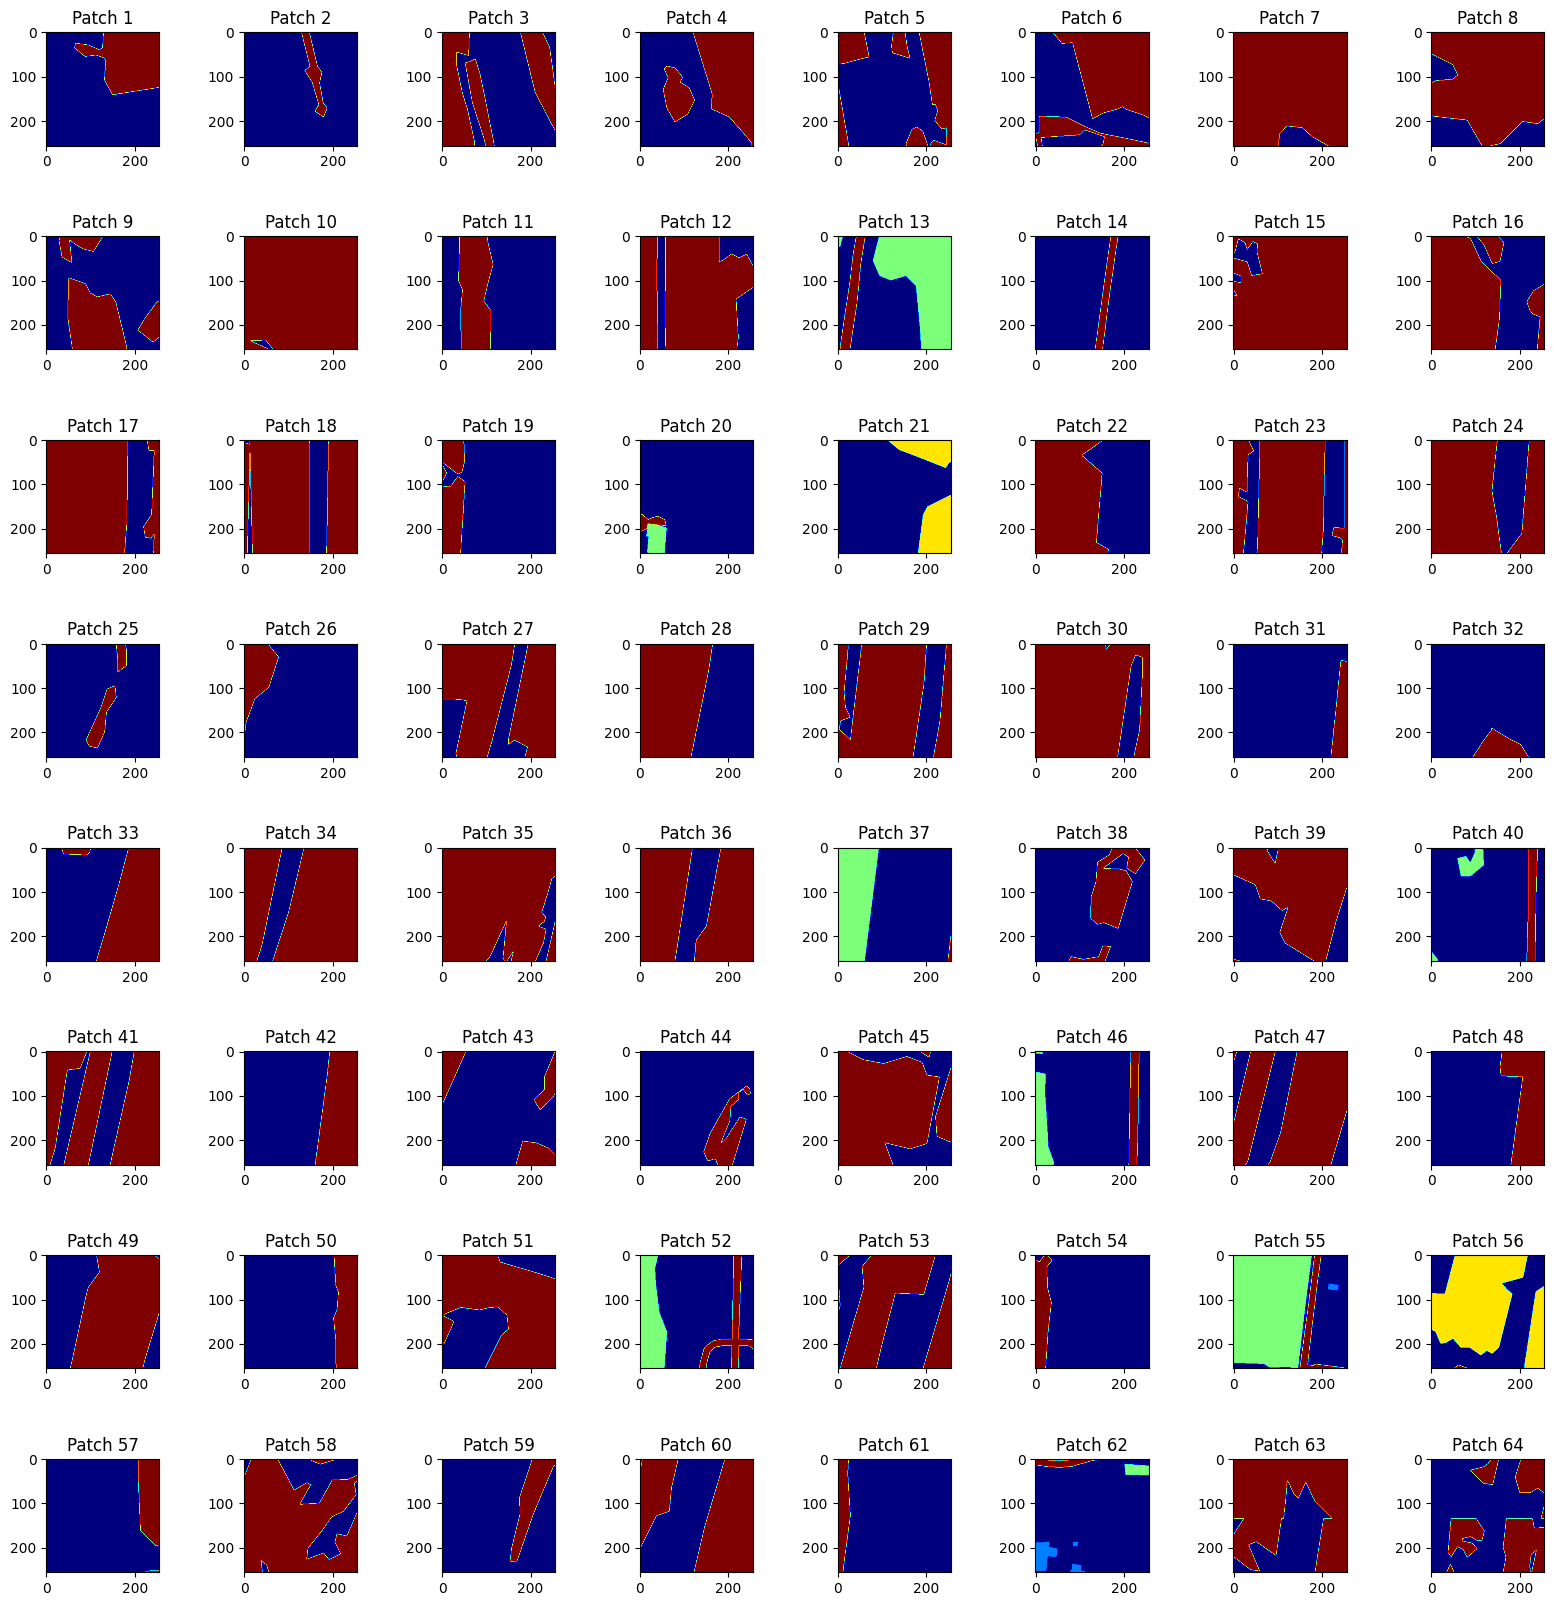

In [20]:
import matplotlib.pyplot as plt

# Create a figure with a larger size
fig = plt.figure(figsize=(20, 20))

# Assuming train_masks contains at least 16 mask images
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)  # Create a 4x4 grid of subplots
    ax.imshow(train_masks[i], cmap='jet') #16 patches make a single image
    ax.set_title(f"Patch {i + 1}")  # Add a title for each subplot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.8)
plt.show()  # Display all 16 images

1/1 [==============================] - 0s 111ms/step


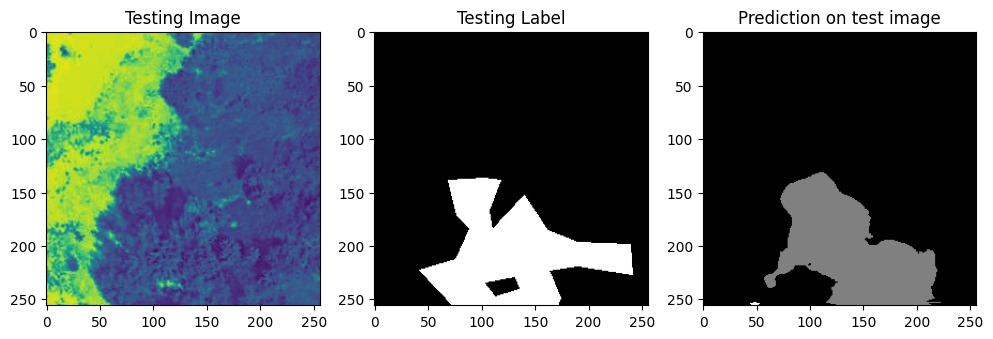

1/1 [==============================] - 0s 102ms/step


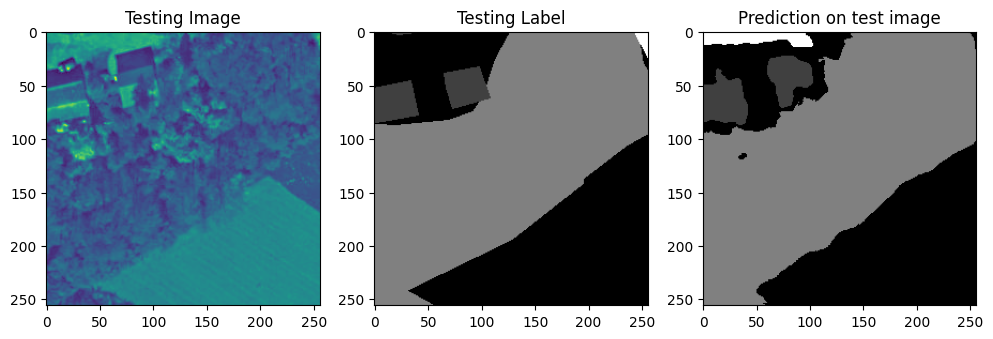

1/1 [==============================] - 0s 105ms/step


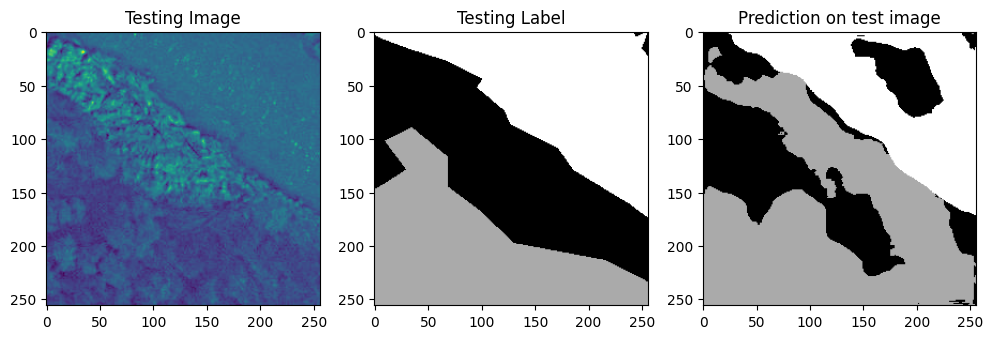

1/1 [==============================] - 0s 102ms/step


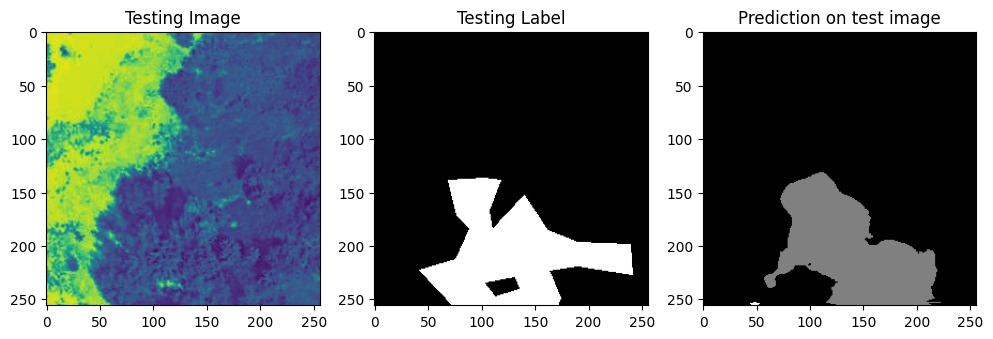

1/1 [==============================] - 0s 100ms/step


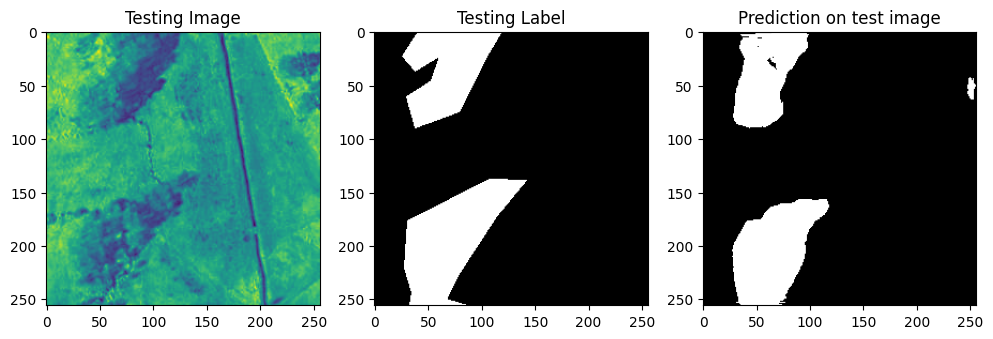

1/1 [==============================] - 0s 97ms/step


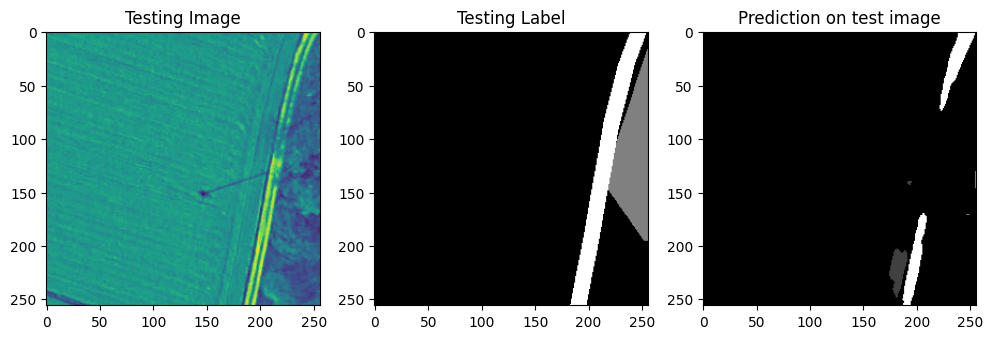

1/1 [==============================] - 0s 98ms/step


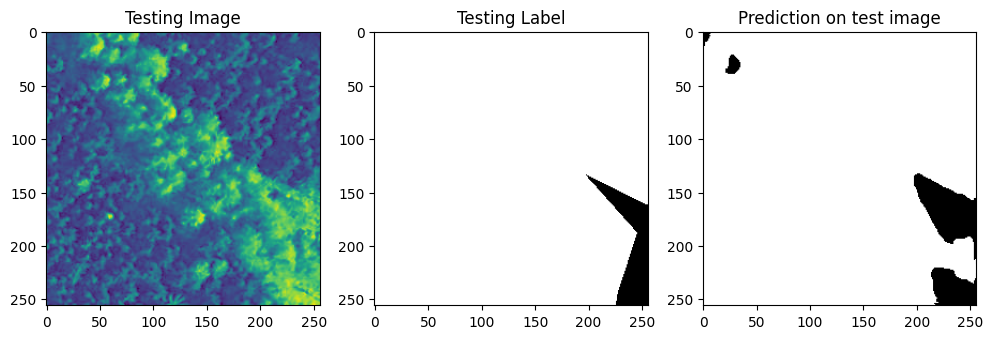

1/1 [==============================] - 0s 98ms/step


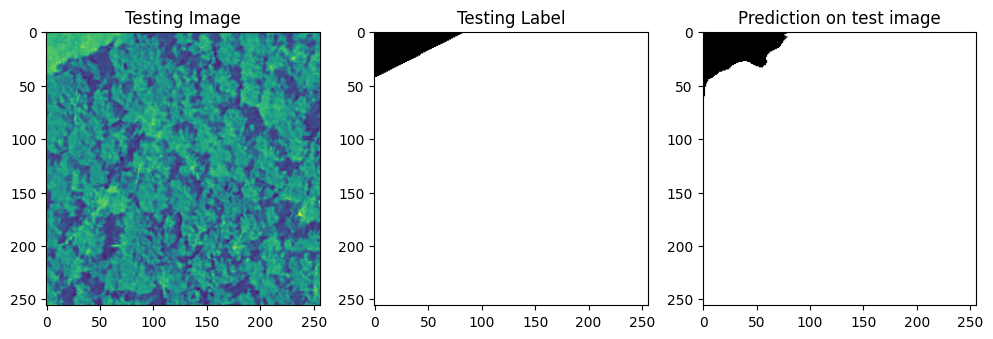

1/1 [==============================] - 0s 99ms/step


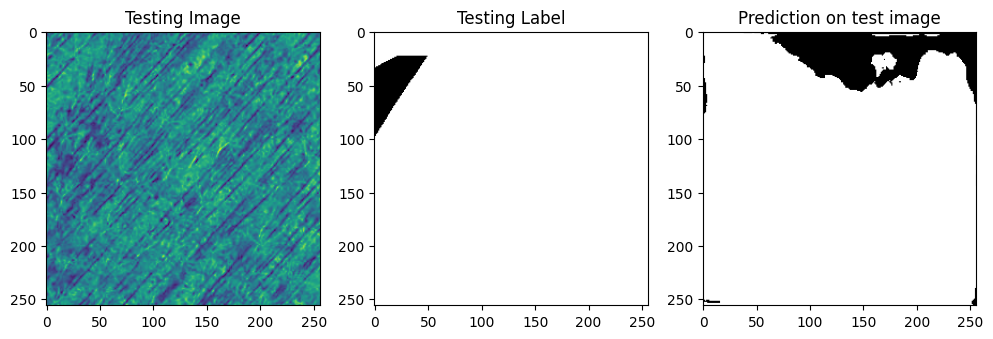

1/1 [==============================] - 0s 97ms/step


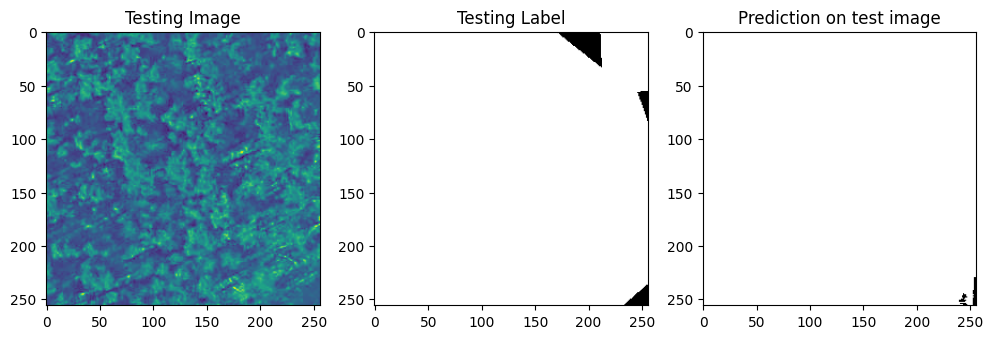

In [21]:
# Test some random images
for j in range(10):
    import random
    test_img_number = random.randint(0, len(X_test1))
    test_img = X_test1[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    
    test_img_input1 = preprocess_input1(test_img_input)
    
    test_pred1 = model1.predict(test_img_input1)
    test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
    
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction1, cmap='gray')
    plt.show()